# Free development of epidemics of tobamovirus

## Introduction
In this notebook an analysis of the time series of simulated epidemics in arcadeSpots3 will take place to get some interesting clues about how do the different tobamovirus behave when they are in their own.

## Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize

In [54]:
pathotypes = ['P0', 'P12', 'P123']
free_data = dict()
for patho in pathotypes:
    print("working with patho = {0}".format(patho))
    free_data[patho] = pd.read_csv('../run1/free_%s/timeSeriesStatistics_%s.csv' % (patho, patho))
    free_data[patho]['sim'] = free_data[patho]['sim '].copy()
    free_data[patho]['epidemic_time'] = free_data[patho]['crop']*180 + free_data[patho]['time']
    del free_data[patho]['sim ']
    print("\tdone")


working with patho = P0
	done
working with patho = P12
	done
working with patho = P123
	done


## Aggregated time series

working with patho = P0
working with patho = P12
working with patho = P123


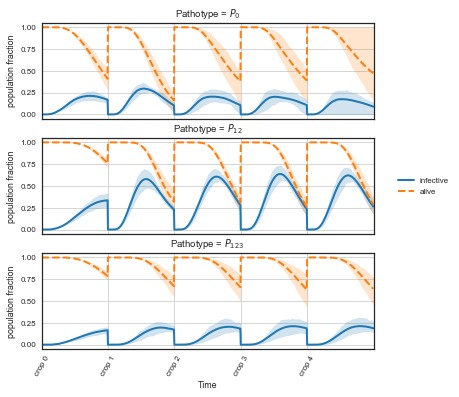

In [72]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(7,6)
i = 0
sns.set_style('whitegrid')
sns.set_palette('tab10')
palette = sns.color_palette('tab10')
labels = ['Pathotype = $P_{0}$', 'Pathotype = $P_{12}$', 'Pathotype = $P_{123}$']
for patho in ['P0', 'P12', 'P123']:
    print("working with patho = {0}".format(patho))
    
    
    free_temp_byEpTime_upper = free_data[patho].groupby(['epidemic_time']).quantile(0.75)
    free_temp_byEpTime_lower = free_data[patho].groupby(['epidemic_time']).quantile(0.25)
    free_temp_byEpTime = free_data[patho].groupby(['epidemic_time']).mean()
    #ax[i].set_title(patho)
    ax[i].set_title(labels[i])
    
    
    free_temp_byEpTime['infective'].plot(ax=ax[i], lw=2, c=palette[0])
    free_temp_byEpTime['alive'].plot(ax=ax[i], lw=2, c=palette[1], linestyle = '--')
    #free_temp_byEpTime_upper['infective'].plot(ax=ax[i], lw=1)
    #free_temp_byEpTime_lower['infective'].plot(ax=ax[i], lw=1)
    #free_temp_byEpTime_upper['alive'].plot(ax=ax[i], lw=1)
    #free_temp_byEpTime_lower['alive'].plot(ax=ax[i], lw=1)
    
    x = free_temp_byEpTime.index.values
    ax[i].fill_between(x, free_temp_byEpTime_lower['infective'], 
                       free_temp_byEpTime_upper['infective'], alpha=.2, color=palette[0])
    
    ax[i].fill_between(x, free_temp_byEpTime_lower['alive'], 
                       free_temp_byEpTime_upper['alive'], alpha=.2, color=palette[1])
    ax[i].set_ylabel('population fraction')
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width * 0.85, box.height])
    if i < 2:
        ax[i].set_xticks([0,180,360,540,720,900])
        ax[i].set_xlabel('')
        ax[i].set_xticklabels('')
    else:
        
        ax[i].set_xticks([0,180,360,540,720,900])
        ax[i].set_xlabel('Time')
        ax[i].set_xticklabels(['crop %d' % i for i in [0,1,2,3,4]], rotation=60)
        
    if i == 1:
        ax[i].legend(bbox_to_anchor=(1.15, 0.5), loc='center')
    
    i+= 1
plt.savefig('C:/Users/Bruno/Dropbox/ARTICULOS/cpv_2016/figures/figure_1.png', dpi=300)
plt.show()

## $R_{0}$ calculations

In [7]:
class SI_r0:
    def __init__(self, **parameters):
        self.__I = parameters['I']

        self.__S = parameters['S']
        self.__I0 = parameters['I0']
        self.__time = parameters['time']
    def simulate(self,x):
        beta = x[0]
        mu = x[1]
        I = np.zeros(self.__time)
        S = np.zeros(self.__time)
        I[0]= self.__I0
        S[0] = 1- I[0]
        for i in range(1,self.__time):
            I[i] = I[i-1] + beta*I[i-1]*S[i-1] - mu*I[i-1]
            S[i] = S[i-1] - beta*I[i-1]*S[i-1]
        return I,S
    def getVal(self,x):
        I,S = self.simulate(x)
        functional = ((I - self.__I) ** 2) + ((S - self.__S) ** 2)
        return np.sum(functional)
    def optimize(self,x0):
        res = minimize(self.getVal, x0, method='Nelder-Mead', tol=1e-6)
        return res.x
def getR2(I,S):
    model = SI_r0(I=I, S=S, I0=0.0001, time=180)
    x0 = [0.1, 0.025]
    x = model.optimize(x0)
    return x[0] / x[1]
        

In [19]:
r0 = dict()

for patho in ['P0', 'P12', 'P123']:
    temp = free_data[patho].drop_duplicates(subset = ['sim', 'epidemic_time'],keep='first')
    temp = temp.query('crop == 0')
    r0[patho] = temp.groupby(['sim']).apply(lambda x : getR2(x['infective'], x['alive']-x['infective']))
    


In [20]:
r0_data_frame = pd.DataFrame(r0)

In [21]:
r0_data_frame = r0_data_frame.stack()
r0_data_frame = pd.DataFrame(r0_data_frame)
r0_data_frame.reset_index(level=0, inplace=True)
r0_data_frame.reset_index(level=0, inplace=True)
r0_data_frame.columns = ['Pathotype', 'sim', 'R0']



In [22]:
r0_data_frame

,Pathotype,sim,R0
0,P0,0,1.604323
1,P12,0,2.624662
2,P123,0,1.751818
3,P0,1,2.327024
4,P12,1,3.784762
5,P123,1,2.325305
6,P0,2,2.939566
7,P12,2,3.655456
8,P123,2,2.035709
9,P0,3,3.561956


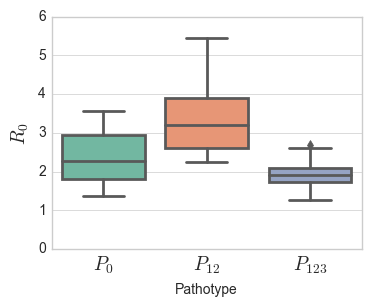

In [29]:
#r0_data_frame.columns = ['Pathotype', 'index', 'R0']
fig, ax = plt.subplots(1)
fig.set_size_inches(4,3)
axx = sns.boxplot(x='Pathotype', y='R0', data=r0_data_frame, ax=ax,linewidth=2)
ax.set_ylabel('$R_{0}$', size = 14)
ax.set_ylim(0, 6)
ax.set_xticklabels(['$P_{0}$', '$P_{12}$', '$P_{123}$'], size=14)
fig.savefig('r0_inference_free.pdf')
plt.show()

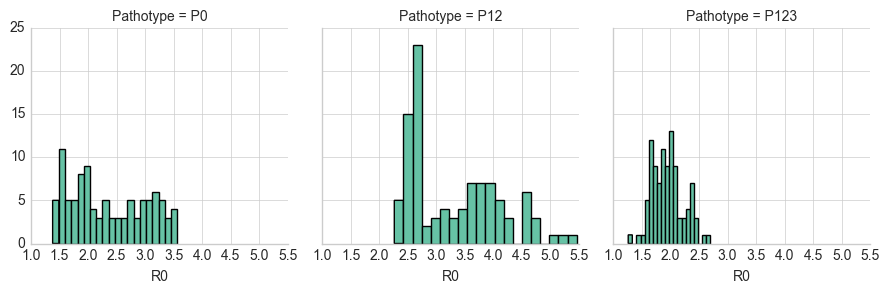

In [49]:
g = sns.FacetGrid(col='Pathotype', data=r0_data_frame)
g = g.map(plt.hist, "R0", bins=20)
plt.show()

In [48]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('R0 ~ Pathotype',
                data=r0_data_frame).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

               sum_sq     df           F        PR(>F)
Pathotype   98.083397    2.0  128.265888  7.041465e-41
Residual   113.556181  297.0         NaN           NaN


In [41]:
pathotypes = ['P0', 'P12', 'P123']
free_data = dict()
for patho in pathotypes:
    print("working with patho = {0}".format(patho))
    free_data[patho] = pd.read_csv('../run1_long/free_%s/timeSeriesStatistics_%s.csv' % (patho, patho))
    free_data[patho]['sim'] = free_data[patho]['sim '].copy()
    free_data[patho]['epidemic_time'] = free_data[patho]['crop']*180 + free_data[patho]['time']
    free_data[patho] = free_data[patho].drop_duplicates(subset=['epidemic_time', 'sim'], keep='first')
    del free_data[patho]['sim ']
    print("\tdone")

working with patho = P0
	done
working with patho = P12
	done
working with patho = P123
	done


In [42]:
persistence = dict()
for patho in free_data.keys():
    temp = free_data[patho].groupby(['crop', 'sim']).apply(lambda x : np.max(x['infective'].values) > 0)
    temp = pd.DataFrame(temp, columns=['epidemic'])
    temp.reset_index(level=0, inplace=True)
    temp.reset_index(level=0, inplace=True)
    temp = temp.groupby('crop').apply(lambda x : np.count_nonzero(x['epidemic'])/100)
    persistence[patho] = temp

In [43]:
persistence['P123']

crop
0     1.00
1     0.87
2     0.84
3     0.83
4     0.81
5     0.80
6     0.77
7     0.74
8     0.70
9     0.70
10    0.70
11    0.66
12    0.62
13    0.59
14    0.56
dtype: float64

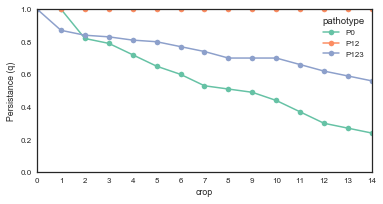

In [44]:
sns.set_style('white')
sns.set_palette('Set2')
palette = sns.color_palette('Set2')
fig, ax = plt.subplots(1)
fig.set_size_inches(6,3)
i = 0
max_val = max([max(i) for i in persistence.values()])
min_val = 0
for patho in ['P0', 'P12', 'P123']:
    persistence[patho].plot(ax=ax, label=patho, lw=1.5, marker='o', mew=0)
ax.legend(loc=0, title = 'pathotype')
ax.set_ylim(min_val, max_val)
ax.set_xticks([i for i in range(15)])
ax.set_ylabel('Persistance (q)')
plt.show()

In [45]:
from scipy.stats import linregress
q = dict()
y0 = dict()
for patho in ['P0', 'P12', 'P123'] :
    res = linregress(persistence[patho].index, np.log(persistence[patho].values))
    q[patho] = res[0]
    y0[patho] = res[1]
q

{'P0': -0.10040223508945161, 'P12': 0.0, 'P123': -0.034372656250922111}

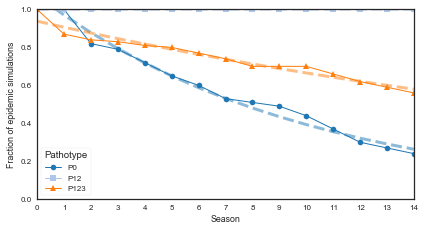

In [71]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6,3.3)
i = 0
max_val = max([max(i) for i in persistence.values()])
min_val = 0
x = np.arange(15)
ccc = sns.color_palette('tab20')
i = 0
marker_dict = dict(P0 = 'o', P12 = 's', P123 = '^')
for patho in ['P0', 'P12', 'P123']:
    persistence[patho].plot(ax=ax, label=patho, lw=1, marker=marker_dict[patho], mew=0, c=ccc[i])
    ax.plot(x, np.exp(y0[patho] + q[patho]*x), c=ccc[i], linestyle='--', alpha=0.5, lw=3)
    i += 1
ax.legend(title = 'Pathotype', loc='lower left')
ax.set_ylim(min_val, max_val)
ax.set_xticks([i for i in range(15)])
ax.set_ylabel('Fraction of epidemic simulations')
ax.set_xlabel('Season')
fig.tight_layout()
fig.savefig('C:/Users/Bruno/Dropbox/ARTICULOS/cpv_2016/figures/figure_2.png', dpi=300)
plt.show()

In [19]:
q_data_frame = pd.DataFrame.from_items(
    [('Pathotype', ['P0', 'P12', 'P123']),
     ('q', [-q['P0'], -q['P12'], -q['P123']])
    ]
)

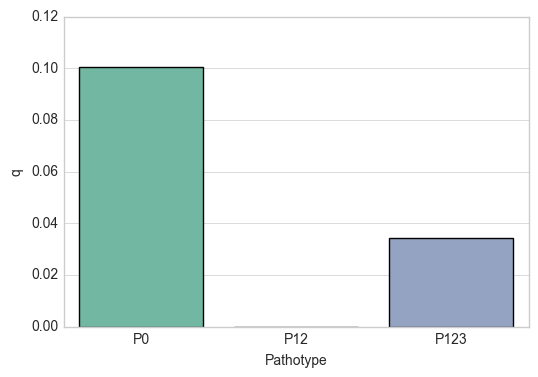

In [150]:
sns.barplot(x='Pathotype', y='q', data=q_data_frame)
plt.show()

In [21]:
q_data_frame['1_q'] = 1-q_data_frame['q']

In [22]:
q_data_frame

,Pathotype,q,1_q
0,P0,0.100402,0.899598
1,P12,-0.000000,1.000000
2,P123,0.034373,0.965627


In [57]:
pathotypes = ['P0', 'P12', 'P123']
competence_data = dict()
for patho in pathotypes:
    print("working with patho = {0}".format(patho))
    competence_data[patho] = pd.read_csv('../run4/timeSeriesStatistics_%s.csv' % (patho))
    competence_data[patho]['sim'] = competence_data[patho]['sim '].copy()
    competence_data[patho]['epidemic_time'] = competence_data[patho]['crop']*180 + competence_data[patho]['time']
    del competence_data[patho]['sim ']
    print("\tdone")

working with patho = P0
	done
working with patho = P12
	done
working with patho = P123
	done


working with patho = P0
working with patho = P12
working with patho = P123


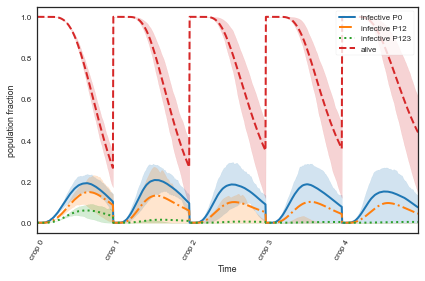

In [66]:
#sns.set_style('whitegrid')
sns.set_palette('tab10')
palette = sns.color_palette('tab10')
sns.set_style('white', {'legend.frameon':True})
fig, ax = plt.subplots(1)
#fig.set_size_inches(8,6)
i = 0
lst = dict(P0='-', P12='-.', P123=':')
for patho in ['P0', 'P12', 'P123']:
    print("working with patho = {0}".format(patho))
    
    
    competence_byEpTime_upper = competence_data[patho].groupby(['epidemic_time']).quantile(0.75)
    competence_byEpTime_lower = competence_data[patho].groupby(['epidemic_time']).quantile(0.25)
    competence_byEpTime = competence_data[patho].groupby(['epidemic_time']).mean()
    #ax[i].set_title(patho)
    
    competence_byEpTime['infective'].plot(
        ax=ax, lw=2, c=palette[i], label = 'infective %s' % patho, linestyle = lst[patho]
    )
    x = competence_byEpTime.index.values
    ax.fill_between(x, competence_byEpTime_lower['infective'], 
                       competence_byEpTime_upper['infective'], alpha=.2, color=palette[i])        
    i += 1
competence_byEpTime['alive'].plot(ax=ax, lw=2, c=palette[3], linestyle='--')
ax.fill_between(
    x, competence_byEpTime_lower['alive'],competence_byEpTime_upper['alive'], alpha=.2, color=palette[3])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.set_xticks([0,180,360,540,720,900])
ax.set_ylabel('population fraction')
ax.set_xlabel('Time')
ax.set_xticklabels(['crop %d' % i for i in [0,1,2,3,4]], rotation=60)


#ax.legend(bbox_to_anchor=(1.15, 0.5), loc='center')
leg = ax.legend(loc = 'upper right', shadow = False)
fig.tight_layout()
fig.savefig('C:/Users/Bruno/Dropbox/ARTICULOS/cpv_2016/figures/figure_5.png', dpi=300)

plt.show()

In [67]:
pathotypes = ['P0', 'P12', 'P123']
competence_data = dict()
for patho in pathotypes:
    print("working with patho = {0}".format(patho))
    competence_data[patho] = pd.read_csv('../run5/timeSeriesStatistics_%s.csv' % (patho))
    competence_data[patho]['sim'] = competence_data[patho]['sim '].copy()
    competence_data[patho]['epidemic_time'] = competence_data[patho]['crop']*180 + competence_data[patho]['time']
    del competence_data[patho]['sim ']
    print("\tdone")

working with patho = P0
	done
working with patho = P12
	done
working with patho = P123
	done


working with patho = P0
working with patho = P12
working with patho = P123


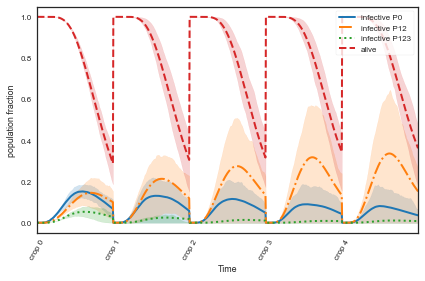

In [69]:
fig, ax = plt.subplots(1)
#fig.set_size_inches(8,6)
i = 0
for patho in ['P0', 'P12', 'P123']:
    print("working with patho = {0}".format(patho))
    
    
    competence_byEpTime_upper = competence_data[patho].groupby(['epidemic_time']).quantile(0.75)
    competence_byEpTime_lower = competence_data[patho].groupby(['epidemic_time']).quantile(0.25)
    competence_byEpTime = competence_data[patho].groupby(['epidemic_time']).mean()
    #ax[i].set_title(patho)
    
    competence_byEpTime['infective'].plot(
        ax=ax, lw=2, c=palette[i], label = 'infective %s' % patho,linestyle = lst[patho]
    )
    x = competence_byEpTime.index.values
    ax.fill_between(x, competence_byEpTime_lower['infective'], 
                       competence_byEpTime_upper['infective'], alpha=.2, color=palette[i])        
    i += 1
competence_byEpTime['alive'].plot(ax=ax, lw=2, c=palette[3], linestyle='--')
ax.fill_between(
    x, competence_byEpTime_lower['alive'],competence_byEpTime_upper['alive'], alpha=.2, color=palette[3])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.set_xticks([0,180,360,540,720,900])
ax.set_ylabel('population fraction')
ax.set_xlabel('Time')
ax.set_xticklabels(['crop %d' % i for i in [0,1,2,3,4]], rotation=60)


leg = ax.legend(loc = 'upper right', shadow = False)#bbox_to_anchor=(1.10, 0.5), loc='center')
#leg.get_frame().set_facecolor('#000000')
fig.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/ARTICULOS/cpv_2016/figures/figure_6.png', dpi=300)

plt.show()

In [16]:
sns.set_context('paper')